In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json

## Process PanCanAtlas file

In [2]:
rna=pd.read_csv("/cellar/users/mpagadal/Data/resources/immune-landscape/EBPlusPlusAdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp.tsv",delimiter="\t")
rna=rna.set_index("gene_id")
rna=rna.T
rna.columns=[x.split("|")[0] for x in rna.columns]

In [3]:
print(rna.shape)

(11069, 20531)


In [4]:
rna["code"]=rna.index.str.split("-").str[3]
rna["barcode"]=rna.index.str[0:12]

In [5]:
canc = pd.read_csv("/nrnb/users/mpagadal/tcga-genotypes/birdseed-processing/gtype.meta", delimiter="\t", header=None)
mp = canc.set_index(2)[0].to_dict()
rna["cancer"]=rna["barcode"].map(mp)

In [6]:
rna_normal=rna[rna["code"].str.startswith("1")]

In [7]:
rna_normal["code"].value_counts()

11A    719
11B     17
11C      1
Name: code, dtype: int64

In [8]:
#convert index to short barcodes
del rna_normal["code"]
del rna_normal["cancer"]
rna_normal.index=rna_normal["barcode"]
del rna_normal["barcode"]

In [9]:
print(rna_normal.shape)

(737, 20531)


In [10]:
cols=[x for x in rna_normal.columns if x!="?"]
rna_normal=rna_normal[cols]

In [11]:
#take mean for individuals with multiple samples
rna=rna_normal
rna=rna.groupby(rna.index).mean()

In [12]:
rna = rna.apply(pd.to_numeric,errors="coerce")

## Retrieve immune microenvironment phenotypes

In [13]:
genes=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/downloaded_phenos/all_rna_lst.txt",delimiter="\t",header=None)[0].tolist()

In [14]:
#map to alternative ids
mp_ids={"CMC2":"C16orf61",
    "ADGRE5":"CD97",
    "SPRYD7":"C13orf1",
    "JCHAIN":"IGJ",
    "CTSL":"CTSL1",
    "CTSV":"CTSL2",
     "TEX30":"C13orf27",
     "CENPU":"MLF1IP",
     "CMSS1":"C3orf26",
     "FAM216A":"C12orf24",
     "HACD2":"PTPLB",
    "MARCHF1":"MARCH1"}

final_genes=[]
for x in genes:
    if x in [x for x in mp_ids.keys()]:
        final_genes.append(mp_ids[x])
    else:
        final_genes.append(x)

### update phenotype dictionary

In [15]:
with open('pheno_dictionary.json', 'r') as f:
    pheno_dict = json.load(f)

In [16]:
for x in mp_ids.keys():
    pheno_dict[mp_ids[x]]=pheno_dict[x]

In [17]:
print("These genes are missing")
[x for x in set(final_genes) if x not in rna.columns]

These genes are missing


['IGLC1', 'HLA-DRB3', 'KIR2DL2', 'IGHG3', 'HLA-DRB4']

In [18]:
final_genes=[x for x in set(final_genes) if x in rna.columns]

In [19]:
#filter for immune genes
rna_immune=rna[final_genes]

In [20]:
rna_immune_final=rna_immune.reset_index().rename(columns={"barcode":"FID"}).set_index("FID")

### Get only phenotypes with less than 10% zero values

In [21]:
def filter_zeros(df,threshold):
    '''
    inputs:
    df: dataframe of rna values
    threshold: % of zero values by which to exclude phenotypes
    
    output:
    dataframe with rna values < threshold of zero values
    '''
    
    keep=[]
    remove=[]
    
    for x in df.columns:
        if len(df[df[x]==0])>threshold*len(df):
            remove.append(x)
        else:
            keep.append(x)
    
    print("{} phenotypes with > {} zeroes were removed".format(len(remove),threshold))
    return(df[keep])
        

In [22]:
rna_immune_final=filter_zeros(rna_immune_final,0.1)

32 phenotypes with > 0.1 zeroes were removed


### filter for genotyped individuals

In [26]:
#get genotyped patients
fam=pd.read_csv("/nrnb/users/mpagadal/tcga-genotypes/imputation/michigan-imputation/HRC/european.final.noimmunecancers.clean.fam",header=None,sep=" ")[0].tolist()

In [40]:
tcga_df=rna_immune_final[rna_immune_final.index.isin(fam)]

In [41]:
print(tcga_df.shape)
tcga_df.head()

(615, 728)


,FCGR2B,CREBBP,IGJ,SEC24B,RUVBL1,TPM2,CXCL9,PSMC4,RAB3C,CD68,...,AP1B1,ITGA6,CSF1R,VSIG4,TAPBP,PSMD5,CD80,CTSF,CD70,MAGOHB
FID,,,,,,,,,,,,,,,,,,,,,
TCGA-22-4593,421.422,1350.88,10413.90,976.143,874.369,1957.21,679.981,1743.52,3.8900,19709.30,...,4618.78,2876.82,6321.07,6944.00,7424.29,996.112,73.6516,1179.72,14.5228,191.131
TCGA-22-4609,542.598,3030.73,21814.60,984.288,465.136,2194.13,1565.290,1082.75,1.0475,9368.02,...,2841.48,2506.98,1948.67,2263.97,5972.77,791.899,65.2933,1265.36,16.0615,203.212
TCGA-22-5471,185.360,2641.27,11806.90,1042.380,891.712,1502.14,182.791,1196.92,0.4281,22016.70,...,3683.65,1818.07,3003.85,8972.17,7131.42,803.082,86.0445,1205.48,2.5685,106.593
TCGA-22-5472,396.713,2901.54,11446.00,1319.300,726.940,3869.23,404.145,1161.69,0.7688,18407.20,...,3880.25,2342.09,4179.07,4731.85,8000.89,847.499,129.4190,1154.00,4.8692,130.187
TCGA-22-5478,377.459,3436.39,4201.46,1180.690,486.700,1086.53,1535.090,1022.02,0.2745,19590.00,...,3211.56,2451.97,2932.10,7374.86,7523.65,949.275,94.4334,1324.81,10.4316,130.120


## Zscore by cancer

In [43]:
tcga_df=tcga_df.reset_index()

In [44]:
canc = pd.read_csv("/nrnb/users/mpagadal/tcga-genotypes/birdseed-processing/gtype.meta", delimiter="\t", header=None)
mp = canc.set_index(2)[0].to_dict()
#total['cancer'] = total["FID"].map(mp)
tcga_df["cancer"]=tcga_df.FID.map(mp)

In [45]:
for x in tcga_df["cancer"].unique():
    try:
        tumor=tcga_df[tcga_df["cancer"]==x]
        del tumor["cancer"]
        tumor.to_csv("/cellar/users/mpagadal/Data/projects/germline-immune/processed_phenos/pancanatlas/normal/pheno_"+x+".unnorm.csv",index=None,sep="\t")
    except:
        print(x)
    
    

### To get inverse rank normalized phenos

Rscript run-rank-norm.R rna_phenos

In [46]:
cancers=tcga_df["cancer"].unique().tolist()

In [47]:
compiled=pd.DataFrame()
for x in cancers:
    df=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/processed_phenos/pancanatlas/normal/pheno_"+x+".rank.csv",delimiter="\t")
    df["cancer"]=x
    compiled=compiled.append(df)

### Confirm phenos are z-scored by cancer

Text(0.5, 1.0, 'FGR')

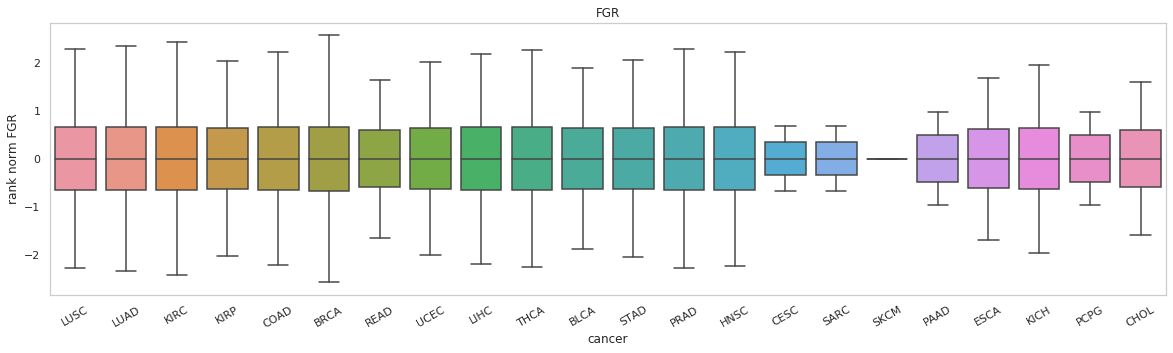

In [48]:
x="FGR"
#plot rna expression by cancer type
sns.set(style="whitegrid", font_scale = 1)
plt.figure(figsize=(20,5))
sns.set_style("whitegrid", {'axes.grid' : False})
ax = sns.boxplot(x="cancer", y=x, data=compiled)
ax.set(xlabel="cancer", ylabel='rank norm FGR')
plt.xticks(rotation=30)
plt.title(x)

## Format for plink

In [49]:
del compiled["cancer"]

In [51]:
compiled["IID"]=compiled["FID"]
cols=["FID","IID"]+compiled.columns.tolist()[1:-1]
compiled=compiled[cols]
compiled.columns=[x.replace("-",".") for x in compiled.columns]
compiled=compiled.fillna(-9)

In [52]:
compiled.to_csv("/cellar/users/mpagadal/Data/projects/germline-immune/processed_phenos/pancanatlas/normal/pheno_all_zcancer",index=None,sep="\t")